# Empirically Matching OM10 Lens Galaxies to SL2S

_Phil Marshall & Bryce Kalmbach, September 2016_

We need to be able to assign a stellar mass and size to each of our OM10 lens galaxies, so that we can, in turn, associate a suitable `CatSim` galaxy (with appropriate SED) with that object. To do this, we will follow Tom Holoien's "empiriciSN" approach, and model the intrinsic distribution of lens galaxy size, stellar mass, redshift and velocity dispersion with the "extreme deconvolution" algorithm.


## Requirements

You will need to have installed Tom Holoien's [`XDGMM`]() and [`empiriciSN`]() packages, as well as their dependencies. 

> By default, in `empiricSN` all the model fitting is done with the [`AstroML`](http://www.astroml.org/index.html) XDGMM algorithm rather than the [Bovy et al. (2011)](https://github.com/jobovy/extreme-deconvolution) algorithm - for this demo you do not need to have the Bovy et al. algorithm installed to run the code. However, we note that the Bovy et al. algorithm is, in general, significantly (i.e., several times) faster. We recommend you try each method on your dataset when using this class.

** _Warning: this notebook is incomplete, having been copied and hacked from the empiriciSN demo..._ **

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import corner
import urllib
import os
from sklearn.cross_validation import train_test_split
from astroML.plotting import setup_text_plots

import empiriciSN
from MatchingLensGalaxies_utilities import *

## Empirical Strong Lens Data

We'll use the SL2S sample of galaxy-scale lenses to model the properties of OM10 lenses. The redshifts and velocity dispersions should cover *most* (but not all) of the LSST lensed quasar sample in OM10.

The data is in Table 3 of [Sonnenfeld et al (2013)](https://arxiv.org/abs/1307.4759), and stored as a csv format file in the Twinkles data folder. (TBC!)

In [2]:
def get_sl2s_data():
    filename = '../../data/SonnenfeldEtal2013_Table3.csv'
    ! wc -l $filename

    z = np.array([])
    z_err = np.array([])
    v_disp = np.array([])
    v_disp_err = np.array([])
    r_eff = np.array([])
    r_eff_err = np.array([])
    log_m = np.array([])
    log_m_err = np.array([])
    
    infile = open(filename, 'r')
    inlines = infile.readlines()
    
    for line1 in inlines:
        if line1[0] == '#': continue
        line = line1.split(',')
        
        #Params
        z = np.append(z, float(line[1]))
        v_disp = np.append(v_disp, float(line[2]))
        r_eff = np.append(r_eff, float(line[3]))
        log_m = np.append(log_m, float(line[4]))
        
        #Errors
        z_err = np.append(z_err, float(line[5]))
        v_disp_err = np.append(v_disp_err, float(line[6]))
        r_eff_err = np.append(r_eff_err, float(line[7]))
        log_m_err = np.append(log_m_err, float(line[8]))
    
    #Build final arrays
    X = np.vstack([z, v_disp, r_eff, log_m]).T
    Xerr = np.zeros(X.shape + X.shape[-1:])
    diag = np.arange(X.shape[-1])
    
    Xerr[:, diag, diag] = np.vstack([z_err**2, v_disp_err**2,
                                    r_eff_err**2, log_m_err**2]).T
    
    return X, Xerr

# Here's what we did to get the csv file:
# ! echo "ID, zlens, vdisp, Reff, Mstar, zlens_err, vdisp_err, Reff_err, Mstar_err" > SonnenfeldEtal2013_Table3.csv  
# ! cat gammaptable.tex | sed s%'&'%%g | sed s%'\$'%%g | sed s%'\\'%%g | sed s%'pm'%'  '%g | sed s%'disky'%%g | awk '{print $1", "$2", "$5", "$3", "$7", 0.001, "$6", 0.01, "$8}' >> SonnenfeldEtal2013_Table3.csv

## Component Test

We could fit our lens galaxy dataset directly, but one problem is that we don't know the optimal number of components (Gaussians) to use in the fit. Knowing the optimal number of components to fit allows us to obtain a good fit in the smallest amount of time without overfitting the data.

### BIC
One way to determine the optimal number of Gaussian components to use in the model is by fitting the model with different numbers of components and calculating the Bayesian information criterion (BIC) for each model. The BIC incorporates the number of components in the model, the sample size, and the likelihood of the data under the model, and the model with the lowest score is the optimal model to use.

We can test for the model with the lowest BIC score for a given dataset using the `component_test` function, which will compute the BIC for a given dataset and range of n_components and return an array containing all the BIC scores as well as the optimal number of components and corresponding BIC value. The code below will read in all the SN and host parameters we want to use from our data files (using the `get_data` function) and use these data to test the performance of the model with n_components ranging from 1 to 8. (Larger numbers of components tend to run into errors occurring because too few observations map to a given Gaussian component. With a bigger dataset, this range could be increased.)

<Note that due to the multiple fits and the large dataset, the BIC test will likely take a while to run, depending on your system.>

In [3]:
# Instantiate an empiriciSN worker object:
empiricist = empiriciSN.Empiricist()

In [4]:
# Define the range of component numbers and read in the dataset:
component_range = np.array([1,2,3,4,5,6,7,8])
X, Xerr = get_sl2s_data()

      26 ../../data/SonnenfeldEtal2013_Table3.csv


In [5]:
# Loop over component numbers, fitting XDGMM model and computing the BIC. 

bics, optimal_n_comp, lowest_bic = empiricist.component_test(X, Xerr, component_range)

N = 1 , BIC = 404.677168861
N = 2 , BIC = 410.426768575
N = 3 , BIC = 442.266672909
N = 4 , BIC = 453.721342867
N = 5 , BIC = 482.676598814
N = 6 , BIC = 513.756618961
N = 7 , BIC = 516.102288131
N = 8 , BIC = 549.019699856


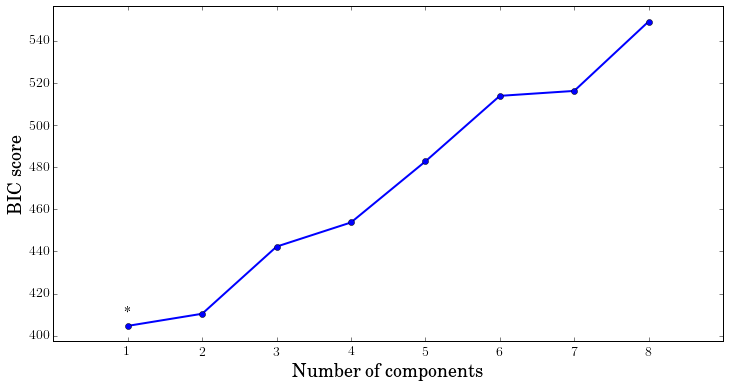

In [6]:
plot_bic(component_range, bics, optimal_n_comp)

> Based on the results of the above test, the model with 1 component has the lowest BIC score and is the optimal choice.


## Fitting a Model

Once we know how many components to use in the model, we can fit a model using that number of components using the `fit_model` function. Before fitting for this demo, we are going to split our lens galaxy dataset 65-35, with the larger subsample being used to fit the model and the smaller subsample providing a test sample that we can use to predict stellar masses and compare with our predicted sample.

In [7]:
# Split the dataset 65/35:
X_train, X_test, Xerr_train, Xerr_test = \
    train_test_split(X, Xerr, test_size=0.35, random_state=42)

# Fit the model:
empiricist.fit_model(X_train, Xerr_train, filename = 'demo_model.fit', n_components=1)
#empiricist.read_model('demo_model.fit')

Note how the `fit_model` function also saves the fit to a file for later re-use. If a model has already been fit, it can be read into an existing `Empiricist` worker, or a new `Empiricist` can be instantiated using the model, like this:

In [8]:
alternative = empiriciSN.Empiricist(model_file='demo_model.fit')

# Print the weights array for each object---they should be the same...
print empiricist.XDGMM.weights
print alternative.XDGMM.weights

[ 1.]
[ 1.]


## Predicting stellar masses of lens galaxies

Our goal in this notebook is to predict the stellar masses of OM10 lens galaxies. Here we use the XDGMM model we just fit on the test data we separated off from the full dataset. We will use the model to predict stellar masses of lens galaxies based upon their redshift, velocity dispersion and radial size.

<The "test" sample generated above gives us a set of 482 host properties that we can use to fit supernovae, and a set of supernova properties to compare with our model fits.>

First, we adapt the "get_logR" function from empiriciSN to "get_log_m" changing the references and restrictions of that method (it only allows certain columns due to structure of SN dataset it uses) to suit our strong lensing dataset.

In [9]:
#Write new conditioning function
def get_log_m(cond_indices, m_index, X, model_file, Xerr=None):
    
    """
        Uses a subset of parameters in the given data to condition the
        model and return a sample value for log(M/M_sun).

        Parameters
        ----------
        cond_indices: array_like
            Array of indices indicating which parameters to use to
            condition the model. 
        m_index: int
            Index of log(M/M_sun) in the list of parameters that were used
            to fit the model.
        X: array_like, shape = (n < n_features,)
            Input data.
        Xerr: array_like, shape = (X.shape,) (optional)
            Error on input data. If none, no error used to condition.

        Returns
        -------
        log_m: float
            Sample value of log(M/M_sun) taken from the conditioned model.

        Notes
        -----
        The fit_params array specifies a list of indices to use to
        condition the model. The model will be conditioned and then
        a mass will be drawn from the conditioned model.

        This is so that the mass can be used to find CATSIM galaxies
        to act as hosts for OM10 systems.

        This does not make assumptions about what parameters are being
        used in the model, but does assume that the model has been
        fit already.
    """

    if m_index in cond_indices:
        raise ValueError("Cannot condition model on log(M/M_sun).")

    cond_data = np.array([])
    if Xerr is not None: cond_err = np.array([])
    m_cond_idx = m_index
    n_features = empiricist.XDGMM.mu.shape[1]
    j = 0

    for i in range(n_features):
        if i in cond_indices:
            cond_data = np.append(cond_data,X[j])
            if Xerr is not None: cond_err = np.append(cond_err, Xerr[j])
            j += 1
            if i < m_index: m_cond_idx -= 1
        else:
            cond_data = np.append(cond_data,np.nan)
            if Xerr is not None: cond_err = np.append(cond_err, 0.0)

    if Xerr is not None:
        cond_XDGMM = empiricist.XDGMM.condition(cond_data, cond_err)
    else: cond_XDGMM = empiricist.XDGMM.condition(cond_data)

    sample = cond_XDGMM.sample()
    log_m = sample[0][m_cond_idx]
    return log_m

With that ready to go, we now use it to get estimates on the stellar mass of our test data from the model we have trained above.

In [10]:
# Get actual masses from dataset, for comparison:
log_m_test = X_test[:,3]

# Predict a mass for each galaxy:
np.random.seed(0)
cond_indices = np.array([0,1,2])
sample_log_m = np.array([])

model_file='demo_model.fit'

for x, xerr in zip(X_test, Xerr_test):
    log_m = get_log_m(cond_indices, 3, x[cond_indices], model_file, Xerr=xerr)
    sample_log_m = np.append(sample_log_m,log_m)
    print x[3], log_m

11.24 11.0627197691
12.1 12.6407859065
11.45 11.7476146494
10.99 10.9755607515
11.14 11.8033402031
11.63 11.7689411067
11.55 11.7048224725
11.97 12.5164037916
11.51 11.9771627646


Now we have a set of test masses in units of log(M/M_sun) and a set of masses sampled from the model. These should have the same distribution when plotted.

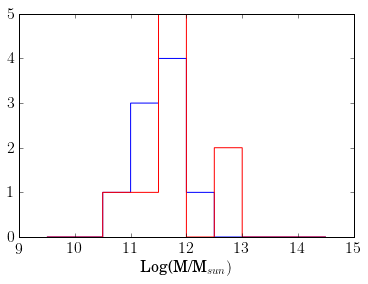

In [11]:
plt.hist(log_m_test, 10, range=(9.5, 14.5), histtype='step')
plt.hist(sample_log_m, 10, range=(9.5, 14.5), color ='r', histtype='step')
plt.xlabel('Log(M/M_{sun})')
plt.show()

We want to make sure that the model gives reasonable values when generating masses, redshift and velocity dispersions. Therefore, we will sample the GMM and plot against the test data.

In [12]:
test_sample = empiricist.XDGMM.sample(size=10000)

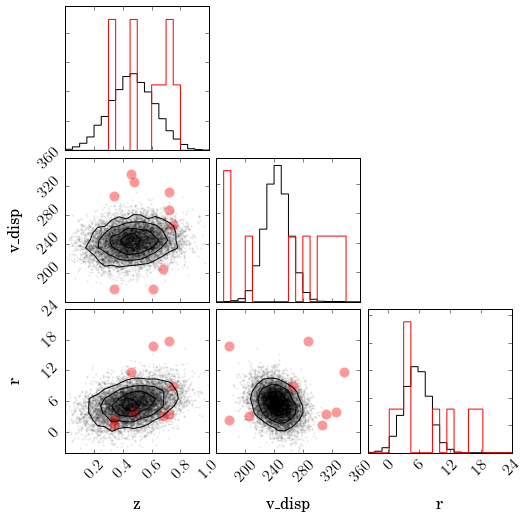

In [13]:
setup_text_plots(fontsize=16, usetex=True)

figure = corner.corner(test_sample[:,:3], labels=['z', 'v\_disp', 'r'], 
                       range = [(0.0, 1.0), (160, 360), (-4, 24)],
              hist_kwargs = {'normed': True}, no_fill_contours=True, 
              plot_density=False)

corner.corner(X_test[:, :3], labels=['z', 'v\_disp', 'r'], color='red', 
              range = [(0.0, 1.0), (160, 360), (-4, 24)],
              hist_kwargs = {'normed':True}, plot_contours=False, 
              plot_density=False, plot_datapoints=True, 
              data_kwargs={'marker':'o', 'alpha':0.4, 'markersize':10}, 
              fig=figure)
plt.show()

In [ ]:
#### Once above is correct we will bring in OM10 systems.

In [ ]:
#plot_separation(log_m_test,sample_log_m)

This predicted radial positions are in fairly good agreement with the training set. 

> With different training/test splits, the predicted distribution can be seen to move around a little within its width, as expected.


### Calculating Local Surface Brightness

Now that we have locations for each test SN, we can calculate the local surface brightness based on the appropriate surface brightness profile (Exponential or de Vaucouleurs) and the host magnitude and effective radius in each filter.

In order to save space here, the actual surface brightness calculation is done in the `get_local_SB` function in the accompanying `demo_funcs` file.

In [ ]:
local_SB = []
local_SB_err = []

for i in range(len(R_param_test)):
    SB, SB_err = empiricist.get_local_SB(R_param_test[i],sample_logR[i])
    local_SB.append(SB)
    local_SB_err.append(SB_err)

local_SB = np.array(local_SB)
local_SB_err = np.array(local_SB_err)

### Predicting Supernova Parameters

Now that we have the local surface brightnesses and separations, we can generate supernova parameters using our full range of host parameters (redshift, separation, colors, and local surface brightnesses). 

First, let's plot the distributions of supernova parameters in our test sample.

In [ ]:
setup_text_plots(fontsize=16, usetex=True)
figure = corner.corner(X_test[:,0:3], labels=['$x_0$','$x_1$','c'],range=[(-0.0001,0.0003),(-4.7,5.0),(-0.5,0.5)])

Next we will use our host properties to predict a supernova for each host, then plot those with the test sample. Ideally, these distributions should be the same as those from the test sample.

In [ ]:
# Set up an array to contain the new supernova properties:
n_Hosts = len(sample_logR)
sample_SNe = np.zeros([n_Hosts,3])

np.random.seed(10)

# Loop over host galaxies, conditioning on each one's properties and drawing one supernova:
for i in range(n_Hosts):
    
    x = np.append(X_test[i][3],sample_logR[i])
    x = np.append(x,X_test[i][5:15])
    x = np.append(x,local_SB[i])
    x = np.append(np.array([np.nan,np.nan,np.nan]),x)
    
    xerr = np.append(np.array([0.0,0.0,0.0]),Xerr_test[i,3,3])
    xerr = np.append(xerr,0.0)
    for j in range(5,15):
        xerr = np.append(xerr,Xerr_test[i,j,j])
    xerr = np.append(xerr,local_SB_err[i])
    
    sample_SNe[i] = empiricist.get_SN(x, Xerr=xerr, n_SN=1)

In [ ]:
# Plot the SNe parameters:
corner.corner(sample_SNe[:,0:3], labels=['$x_0$','$x_1$','c'], color='red',
                                 fig=figure, range=[(-0.0001,0.0003),(-4.7,5.0),(-0.5,0.5)])

Not too bad overall. Given a larger test sample, this would likely look a bit better, but we are dealing with fairly small sample sizes.

Finally, let's take a look at the distribution of properties for a single radius in a single host galaxy. By sampling 1000 different supernovae at that position, we can see how the model has been conditioned to that host. We should see a significantly different distribution of supernova parameters from the previous plot, if supernova properties depend on either their positions within their hosts, or their host's properties, or both.

In [ ]:
# Choose one (host galaxy, radial position) combination:
i = 10

np.random.seed(10)

# Set up the conditioning data:
x = np.append(X_test[i][3], sample_logR[i])
x = np.append(x, X_test[i][5:15])
x = np.append(x, local_SB[i])
x = np.append(np.array([np.nan, np.nan, np.nan]), x)

xerr = np.append(np.array([0.0,0.0,0.0]), Xerr_test[i,3,3])
xerr = np.append(xerr, 0.0)
for j in range(5,15):
    xerr = np.append(xerr, Xerr_test[i,j,j])
xerr = np.append(xerr, local_SB_err[i])

# Draw a thousand SNe:
sample_SNe = empiricist.get_SN(x, Xerr=xerr, n_SN=1000)

In [ ]:
# Plot the SNe parameters:
corner.corner(sample_SNe[:,0:3], labels=['$x_0$','$x_1$','c'], color='blue',
                                 fig=figure, range=[(-0.0001,0.0003),(-4.7,5.0),(-0.5,0.5)])

As we can see, the distributions for the various properties can be quite different for a single position in a single host than what they are for the full sample: where the supernova happens, matters.